In [1]:
using CSV, StatsBase, Statistics, DataFrames, UMAP, RCall, FreqTables
using MultipleTesting, Random, MultivariateStats, Distributed
using BioProfiling

┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1278
┌ Warning: Module StatsFuns with build ID 523458579000110 is missing from the cache.
│ This may mean StatsFuns [4c63d2b9-4356-54db-8cca-17b64c39e42c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1017
┌ Warning: Module StatsFuns with build ID 523458579000110 is missing from the cache.
│ This may mean StatsFuns [4c63d2b9-4356-54db-8cca-17b64c39e42c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1017
┌ Info: Skipping precompilation since __precompile__(false). Importing RCall [6f49c342-dc21-5d91-9882-a32aef131414].
└ @ Base loading.jl:1034
┌ Warning: Replacing module `StatsFuns`
└ @ Base loading.jl:948
┌ Info: Precompiling MultipleTesting [f8716d33-7c4a-5097-896f-ce0ecbd3ef6b]
└ @ Base loading.jl:1278
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for MultipleTesting [f871

In [2]:
using Dates: now
now()

2021-05-07T15:49:27.286

In [3]:
# This is the location where the images are stored
# (useful to highlight cells of a given morphology)
img_folder = "/images/"

"/images/"

In [4]:
readdir(img_folder)

233-element Array{String,1}:
 "r01c02f07p01rc1-ch1sk1fk1fl1.tiff"
 "r01c02f07p01rc2-ch1sk1fk1fl1.tiff"
 "r01c02f07p01rc3-ch1sk1fk1fl1.tiff"
 "r01c14f16p01rc1-ch1sk1fk1fl1.tiff"
 "r01c14f16p01rc2-ch1sk1fk1fl1.tiff"
 "r01c14f16p01rc3-ch1sk1fk1fl1.tiff"
 "r01c14f19p01rc1-ch1sk1fk1fl1.tiff"
 "r01c14f19p01rc2-ch1sk1fk1fl1.tiff"
 "r01c14f19p01rc3-ch1sk1fk1fl1.tiff"
 "r01c17f04p01rc1-ch1sk1fk1fl1.tiff"
 "r01c17f04p01rc2-ch1sk1fk1fl1.tiff"
 "r01c17f04p01rc3-ch1sk1fk1fl1.tiff"
 "r02c02f07p01rc1-ch1sk1fk1fl1.tiff"
 ⋮
 "r14c14f15p01rc1-ch1sk1fk1fl1.tiff"
 "r14c14f15p01rc2-ch1sk1fk1fl1.tiff"
 "r14c14f15p01rc3-ch1sk1fk1fl1.tiff"
 "r14c20f09p01rc1-ch1sk1fk1fl1.tiff"
 "r14c20f09p01rc2-ch1sk1fk1fl1.tiff"
 "r14c20f09p01rc3-ch1sk1fk1fl1.tiff"
 "r15c11f16p01rc1-ch1sk1fk1fl1.tiff"
 "r15c11f16p01rc2-ch1sk1fk1fl1.tiff"
 "r15c11f16p01rc3-ch1sk1fk1fl1.tiff"
 "r15c22f02p01rc1-ch1sk1fk1fl1.tiff"
 "r15c22f02p01rc2-ch1sk1fk1fl1.tiff"
 "r15c22f02p01rc3-ch1sk1fk1fl1.tiff"

## R Calls

In [5]:
@rlibrary ggplot2
@rlibrary extrafont
@rlibrary viridis
@rlibrary heatmaply
@rlibrary ggrepel

In [6]:
R"""
# Used later for MCD computation

library(robustbase)

# Customize ggplot appearance

library(ggplot2)
library(extrafont)


# Load extra fonts
# ttf_import("/tmp/.fonts")
# loadfonts()

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), 
                     legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)
"""

┌ Warning: RCall.jl: Registering fonts with R
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160


RObject{VecSxp}
$repr.plot.width
NULL

$repr.plot.height
NULL



## Load measurements

### Load annotations

In [7]:
annotations = CSV.read("data/transferList.txt", DataFrame, header = 1, delim = "\t")
# Convert plate number to strings to make clear it is an ID and should not be used for computations
annotations[!, :DestinationPlate] = string.(annotations[:,:DestinationPlate])
# Wells in the transfer list without any compound name are filled with DMSO only
annotations[!, :CompoundName][ismissing.(annotations[:,:CompoundName])] .= "DMSO"
# A non-ASCII characters needs to be converted
annotations.CompoundName = replace.(annotations.CompoundName, "\xb1" => s"±");

In [8]:
annotations

,DestWell,SourcePlate_A,SrcWell_A,DestinationPlate,Type_A,VolumeTransferred_A
,String,String,String,String,String,Int64
1,A01,CLOMP_D4,M04,1914001,Cpd,100
2,A02,CLOUD10mM10,I19,1914001,Cpd,100
3,A03,CLOUD10mM10,A10,1914001,Cpd,100
4,A04,CLOMP002a,L04,1914001,Cpd,100
5,A05,CLOUD10mM10,I05,1914001,Cpd,100
6,A06,CLOMP002a,B11,1914001,Cpd,100
7,A07,CLOMP001a,F15,1914001,Cpd,10
8,A08,CLOMP003a,I20,1914001,Cpd,100
9,A09,CLOUD10mM10,M19,1914001,Cpd,100


### Load image data

In [9]:
image = CSV.read("data/compiled_PilotDrugScreen_Image_1500.csv", DataFrame)
println(string.(names(image))[1:8])
# Number of images and features available
println(nrow(image))
println(ncol(image))

["Column1", "AreaOccupied_AreaOccupied_CytoCM", "AreaOccupied_AreaOccupied_Cytoplasm", "AreaOccupied_AreaOccupied_Nucleus", "AreaOccupied_Perimeter_CytoCM", "AreaOccupied_Perimeter_Cytoplasm", "AreaOccupied_Perimeter_Nucleus", "AreaOccupied_TotalArea_CytoCM"]
7680
1916


### Load individual cell files

In [10]:
nucleus = CSV.read("data/compiled_PilotDrugScreen_Nucleus_1500.csv", DataFrame, header = 1);

In [11]:
# Remove duplicated columns
nucleus = nucleus[:, Not([1,6,8,12,14,16])];

In [12]:
cytocm = CSV.read("data/compiled_PilotDrugScreen_CytoCM_1500.csv", DataFrame, header = 1);

In [13]:
# Remove duplicated columns
cytocm = cytocm[:, Not([1,6,8,12,14,16])];

In [14]:
cytoplasm = CSV.read("data/compiled_PilotDrugScreen_Cytoplasm_1500.csv", DataFrame, header = 1);

In [15]:
# Remove duplicated columns
cytoplasm = cytoplasm[:, Not([1,6,8,12,14,16])];

### Merge measurements

In [16]:
cell = innerjoin(cytoplasm, cytocm, on = [:ImageNumber => :ImageNumber, :Parent_CytoCM => :ObjectNumber], 
       makeunique = true)

,ImageNumber,ObjectNumber,Metadata_Channel,Metadata_Column,Metadata_Field,Metadata_FileLocation
,Int64,Int64,Missing,Int64,Int64,Missing
1,1393,5,missing,3,4,missing
2,1393,7,missing,3,4,missing
3,1393,9,missing,3,4,missing
4,1393,12,missing,3,4,missing
5,1393,13,missing,3,4,missing
6,1393,14,missing,3,4,missing
7,1393,15,missing,3,4,missing
8,1393,16,missing,3,4,missing
9,1393,17,missing,3,4,missing


In [17]:
cell = innerjoin(cell, nucleus, on = [:ImageNumber => :ImageNumber, :Parent_Nucleus => :ObjectNumber], 
       makeunique = true)

,ImageNumber,ObjectNumber,Metadata_Channel,Metadata_Column,Metadata_Field,Metadata_FileLocation
,Int64,Int64,Missing,Int64,Int64,Missing
1,1393,5,missing,3,4,missing
2,1393,7,missing,3,4,missing
3,1393,9,missing,3,4,missing
4,1393,12,missing,3,4,missing
5,1393,13,missing,3,4,missing
6,1393,14,missing,3,4,missing
7,1393,15,missing,3,4,missing
8,1393,16,missing,3,4,missing
9,1393,17,missing,3,4,missing


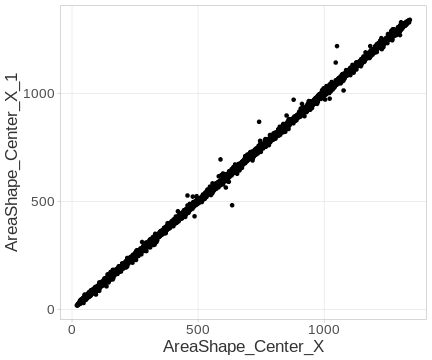

RObject{VecSxp}


In [18]:
# NB: columns with missing values should not be provided even if they are not used by ggplot
ggplot(cell[1:10000,[:AreaShape_Center_X, :AreaShape_Center_X_1]], 
       aes(x = :AreaShape_Center_X, y = :AreaShape_Center_X_1)) + geom_point()

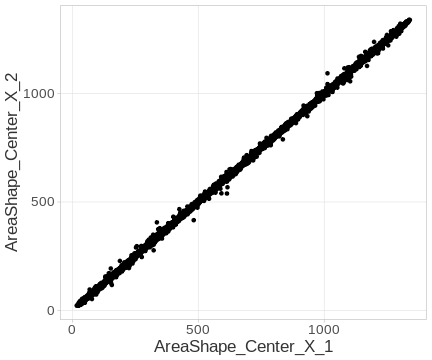

RObject{VecSxp}


In [19]:
# NB: columns with missing values should not be provided even if they are not used by ggplot
ggplot(cell[1:10000,[:AreaShape_Center_X_1, :AreaShape_Center_X_2]], 
       aes(x = :AreaShape_Center_X_1, y = :AreaShape_Center_X_2)) + geom_point()

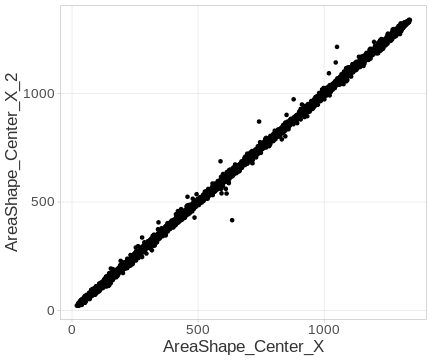

RObject{VecSxp}


In [20]:
# NB: columns with missing values should not be provided even if they are not used by ggplot
ggplot(cell[1:10000,[:AreaShape_Center_X, :AreaShape_Center_X_2]], 
       aes(x = :AreaShape_Center_X, y = :AreaShape_Center_X_2)) + geom_point()

In [21]:
# Free up memory
nucleus = nothing
cytoplasm = nothing
cytocm = nothing

## Experiment filtering

In [22]:
cell.URL = "/images/r".*lpad.(cell.Metadata_Row, 2, "0").*
    "c".*lpad.(cell.Metadata_Column, 2, "0").*
    "f".*lpad.(cell.Metadata_Field, 2, "0").*"p01rc1-ch1sk1fk1fl1.tiff";

In [23]:
cell.PlateNumber = [x == "1500CellsPerWell" ? "1914001" : "1914011" for x in cell.Metadata_Plate];

In [24]:
cell = leftjoin(cell, annotations[:,[:CompoundName,:DestWell,:DestinationPlate]], 
                    on = [:Metadata_Well => :DestWell, :PlateNumber => :DestinationPlate])

# Wells absent of the transfer list do not have any compound in them
cell.CompoundName[ismissing.(cell.CompoundName), :] .= "None";

```julia
# Export `cell` dataframe to avoid reprocessing if not needed
CSV.write("data/compiled_cell_1500.csv", cell)
```

```julia
# If data was already compiled and exported, load the `cell` dataframe.
cell = CSV.read("data/compiled_cell_1500.csv", DataFrame)
```

In [25]:
CSV.write("data/compiled_cell_1500.csv", cell)

"data/compiled_cell_1500.csv"

In [26]:
ftb = freqtable(cell.CompoundName)
ftb[sortperm(ftb)]

313-element Named Array{Int64,1}
Dim1                                                                   │ 
───────────────────────────────────────────────────────────────────────┼───────
Pentamidine isethionate                                                │     18
Sanguinarine chloride                                                  │     28
Parthenolide                                                           │     68
Auranofin                                                              │     73
Calcimycin                                                             │     76
Bay 11-7085                                                            │     88
Bortezomib                                                             │     89
Vorinostat                                                             │     92
Quinacrine dihydrochloride                                             │     96
Digitoxin                                                              │    108
Cinacalcet   

In [27]:
xp = Experiment(cell, description = "All measurements for plate @1500c/well.")

"Experiment with 3125198/3125198 entries and 798/798 features selected."

In [28]:
# Make sure to remove columns that are not morphological measurements
strToRemove = ["Parent", "ObjectNumber", "ImageNumber", "Experiment",
                "Object_Number", "Location", "Center", "Metadata", "Orientation",
                "PlateNumber", "CompoundName", "Texture", "Neighbors_AngleBetweenNeighbors_5",
                "Neighbors_SecondClosestDistance_5", "URL"]
# NB: Textural features have missing values
filters = Array{BioProfiling.AbstractReduce}([NameSelector(x -> !any(occursin.(strToRemove, String(x))))])

1-element Array{BioProfiling.AbstractReduce,1}:
 NameSelector(var"#3#4"(), "No description provided")

### Which cells to filter?

In [29]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 500, :height => 400))

Ptr{VecSxp} @0x000000000ba441a8

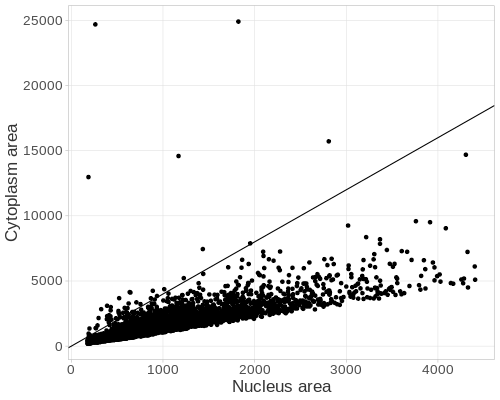

RObject{VecSxp}


In [30]:
# Cells with cytoCM much larger than nucleus
ggplot(cell[1:10000,[:AreaShape_Area_2, :AreaShape_Area_1]], 
       aes(x = :AreaShape_Area_2, y = :AreaShape_Area_1)) + 
    geom_point() +
    geom_abline(intercept = 0, slope = 4) +
    xlab("Nucleus area") +
    ylab("Cytoplasm area") +
    RObject(nothing)

In [31]:
cell.Metadata_Ratio1 = cell.AreaShape_Area_1 ./ cell.AreaShape_Area_2
push!(filters, Filter(4, :Metadata_Ratio1, 
        compare = <, 
        description = "Exclude cells with really large cytoCM"))
negf1 = negation(filters[end]);

In [32]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 500, :height => 500))

Ptr{VecSxp} @0x000000031c49c2f0

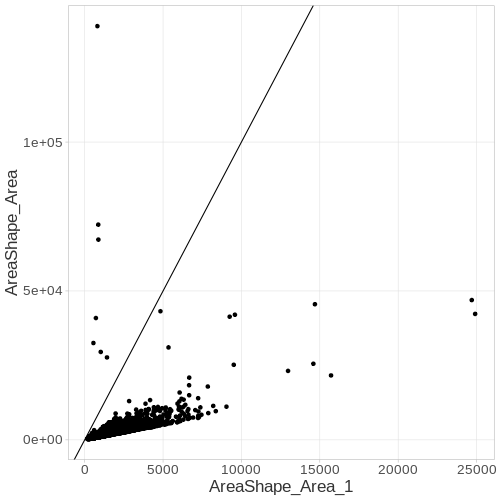

RObject{VecSxp}


In [33]:
# Cells with cytoplasm much larger than cytoCM
ggplot(cell[1:10000,[:AreaShape_Area, :AreaShape_Area_1]], 
       aes(x = :AreaShape_Area_1, y = :AreaShape_Area)) + geom_point() +
    geom_abline(intercept = 0, slope = 10)

In [34]:
cell.Metadata_Ratio2 = cell.AreaShape_Area ./ cell.AreaShape_Area_1
push!(filters, Filter(10, :Metadata_Ratio2, compare = <, description = "Exclude cells with really large cytoplasm"))
negf2 = negation(filters[end]);

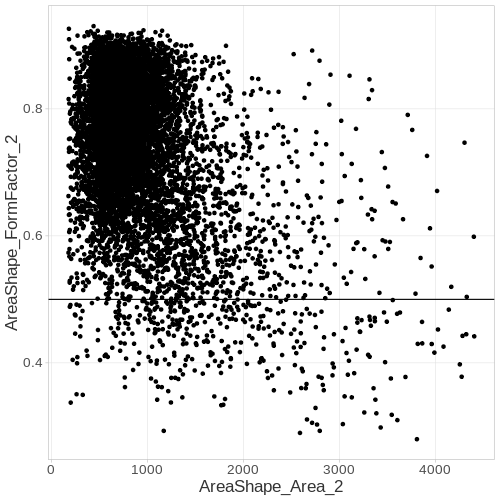

RObject{VecSxp}


In [35]:
# Cells with non-round nuclei (mostly segmentation mistakes)
ggplot(cell[1:10000,[:AreaShape_Area_2, :AreaShape_FormFactor_2]], 
       aes(x = :AreaShape_Area_2, y = :AreaShape_FormFactor_2)) + geom_point() +
    geom_hline(yintercept = 0.5)

In [36]:
push!(filters, Filter(0.5, :AreaShape_FormFactor_2, compare = >, description = "Keep roundish nuclei"))
negf3 = negation(filters[end]);

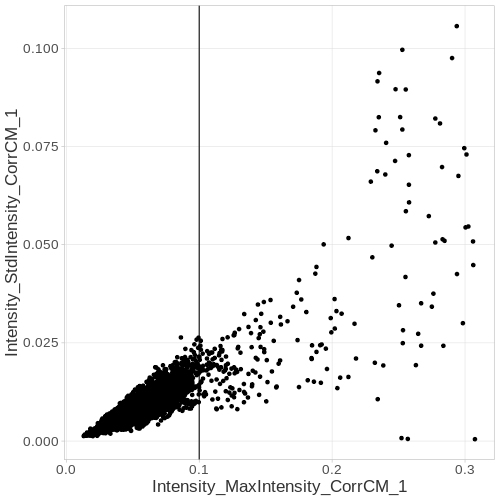

RObject{VecSxp}


In [37]:
# Cells with CellMask clots
ggplot(cell[1:10000,[:Intensity_MaxIntensity_CorrCM_1, :Intensity_StdIntensity_CorrCM_1]], 
       aes(x = :Intensity_MaxIntensity_CorrCM_1, y = :Intensity_StdIntensity_CorrCM_1)) + geom_point() +
    geom_vline(xintercept = 0.1)

In [38]:
push!(filters, Filter(0.1, :Intensity_MaxIntensity_CorrCM_1, compare = <, description = "Keep roundish nuclei"))
negf4 = negation(filters[end]);

### Example images
Here we highlight examples of cells which were filtered out and cells which were kept. 

In [39]:
# Convert paths to all channels
rgbrgx = [
    ["rc1" => "rc3"],
    ["rc1" => "rc2"],
    []]

3-element Array{Array{Any,1},1}:
 ["rc1" => "rc3"]
 ["rc1" => "rc2"]
 []

In [40]:
# This is the description of the cells highlighted (i.e. they have an usually large cytoCM)
allImgToCopy = [diagnostic_path(xp, negf1, :URL, center = false)[1:3]...,
diagnostic_path(xp, negf2, :URL, center = false)[1:3]...,
diagnostic_path(xp, negf3, :URL, center = false)[1:3]...,
diagnostic_path(xp, negf4, :URL, center = false)[1:3]...]

12-element Array{String,1}:
 "/images/r09c03f04p01rc1-ch1sk1fk1fl1.tiff"
 "/images/r13c03f04p01rc1-ch1sk1fk1fl1.tiff"
 "/images/r16c17f03p01rc1-ch1sk1fk1fl1.tiff"
 "/images/r15c17f03p01rc1-ch1sk1fk1fl1.tiff"
 "/images/r15c02f06p01rc1-ch1sk1fk1fl1.tiff"
 "/images/r03c14f16p01rc1-ch1sk1fk1fl1.tiff"
 "/images/r09c03f04p01rc1-ch1sk1fk1fl1.tiff"
 "/images/r10c03f04p01rc1-ch1sk1fk1fl1.tiff"
 "/images/r11c03f04p01rc1-ch1sk1fk1fl1.tiff"
 "/images/r09c03f04p01rc1-ch1sk1fk1fl1.tiff"
 "/images/r10c03f04p01rc1-ch1sk1fk1fl1.tiff"
 "/images/r11c03f04p01rc1-ch1sk1fk1fl1.tiff"

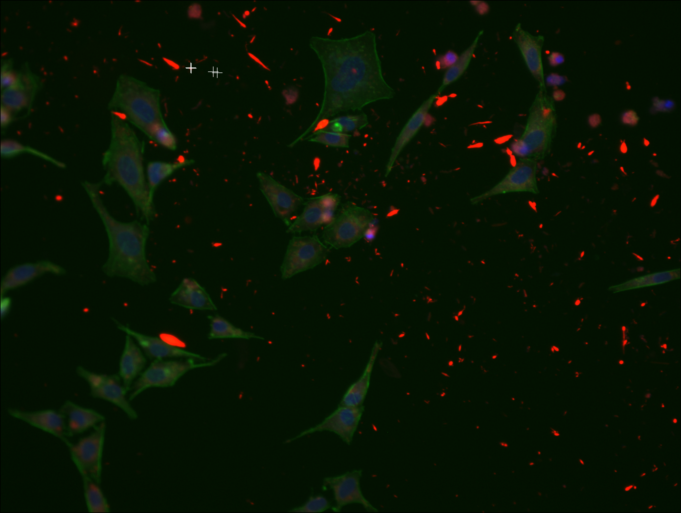

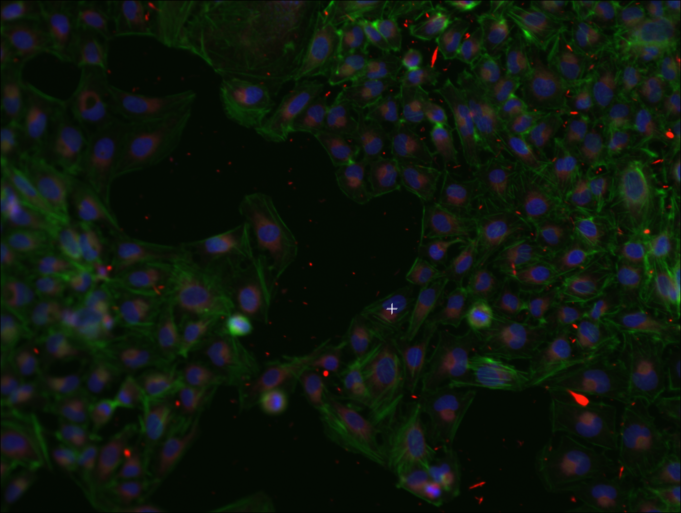

Do not Exclude cells with really large cytoCM


LoadError: [91mArgumentError: No file exists at given path: /images/r16c17f03p01rc3-ch1sk1fk1fl1.tiff[39m

In [41]:
# This is the description of the cells highlighted (i.e. they have an usually large cytoCM)
println(negf1.description)
diagnostic_images(xp, negf1, :URL, 
                    saveimages = false, show = true,
                    rgb = rgbrgx, showlimit = 3, center = true)

In [42]:
println(negf2.description)
diagnostic_images(xp, negf2, :URL, 
                    saveimages = false, show = true,
                    rgb = rgbrgx, showlimit = 3, center = true)

Do not Exclude cells with really large cytoplasm


LoadError: [91mArgumentError: No file exists at given path: /images/r15c17f03p01rc3-ch1sk1fk1fl1.tiff[39m

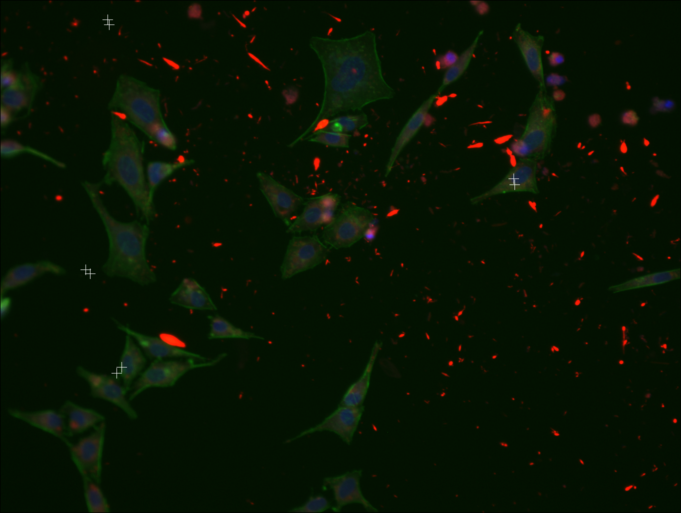

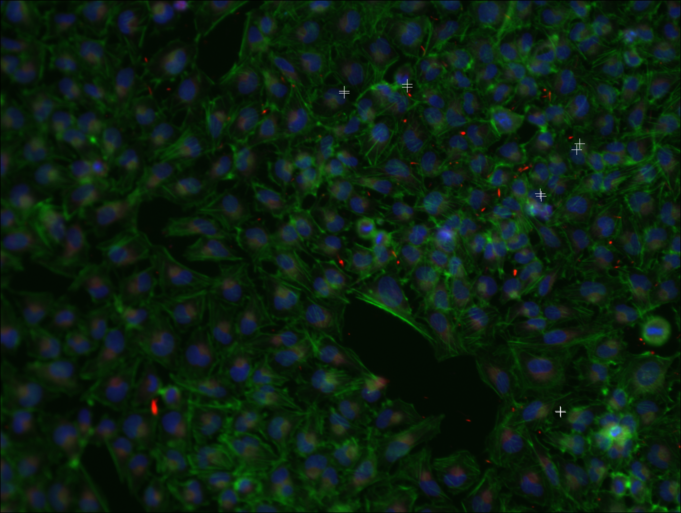

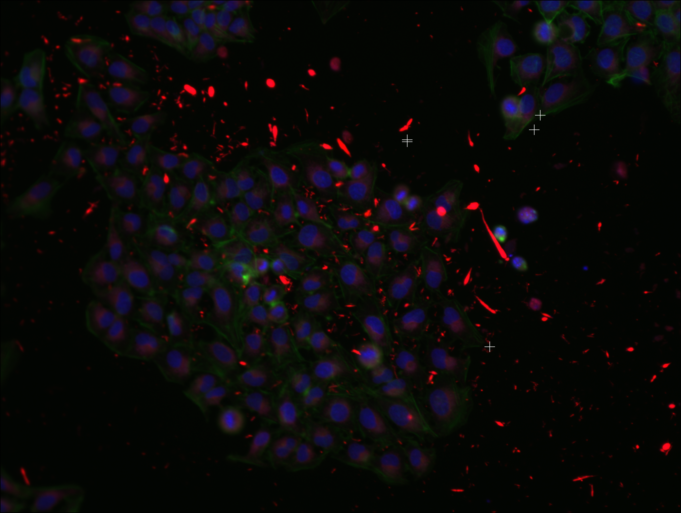

Do not Keep roundish nuclei


true

In [43]:
println(negf3.description)
diagnostic_images(xp, negf3, :URL, 
                    saveimages = false, show = true,
                    rgb = rgbrgx, showlimit = 3, center = true)

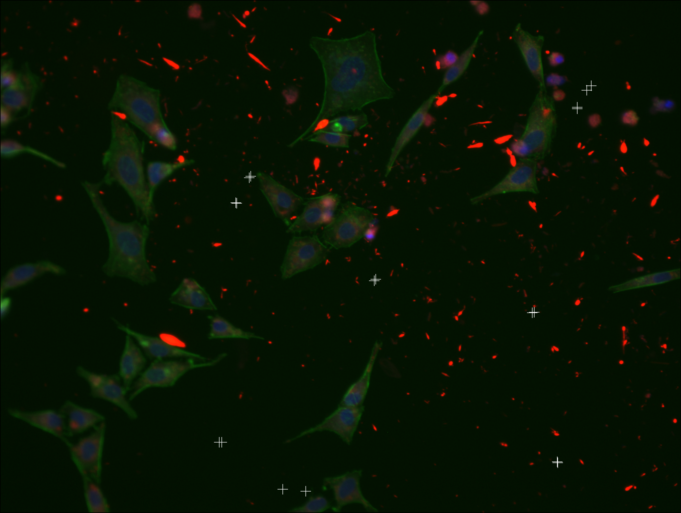

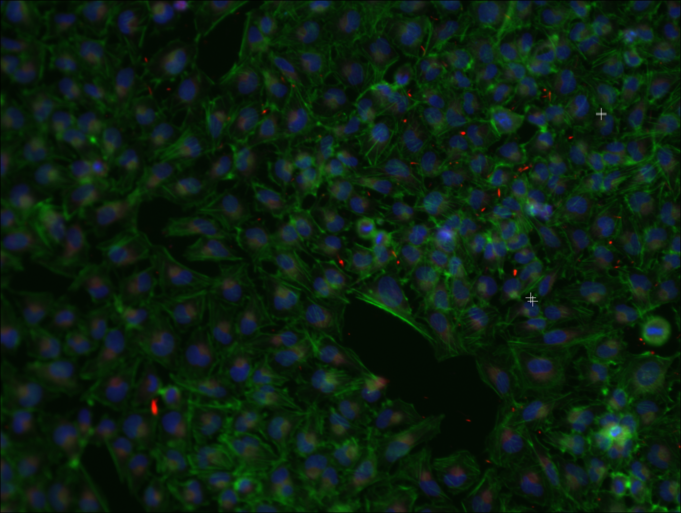

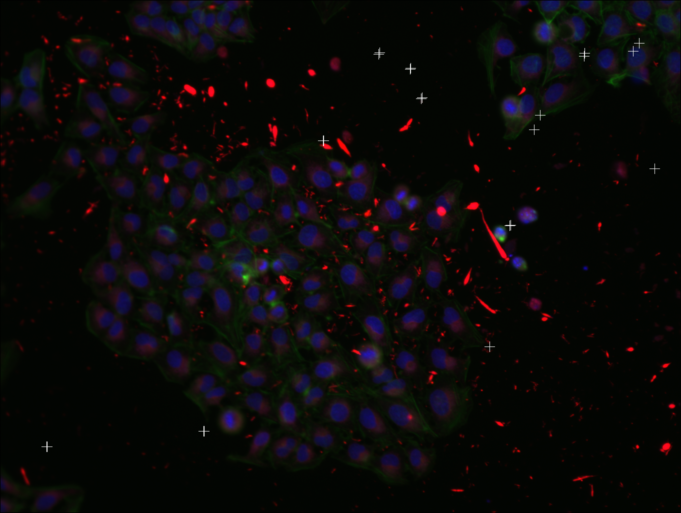

Do not Keep roundish nuclei


true

In [44]:
println(negf4.description)
diagnostic_images(xp, negf4, :URL, 
                    saveimages = false, show = true,
                    rgb = rgbrgx, showlimit = 3, center = true)

### Apply filters

In [45]:
select!(xp, filters)

In [46]:
# No measurements are missing!
tdf = xp.data[xp.selected_entries, xp.selected_features]
@assert sum(Array(mapcols(x -> sum(ismissing.(x)), tdf))[1,:]) == 0
# Free up memory
tdf = nothing

```julia
# Remove constant columns
push!(filters, Selector(x -> mad(x, normalize = true) != 0, description = "Remove constant features"));
push!(filters, Selector(x -> mad(x, normalize = true) != 0, 
                        subset = x -> x.CompoundName .== "DMSO", 
                        description = "Remove features constant for reference"));
```

In [47]:
xp

"Experiment with 2976306/3125198 entries and 385/800 features selected."

## Coarse-grain aggregation

In [48]:
gd = groupby(xp.data[xp.selected_entries,[xp.selected_features...,
                                           findfirst(names(xp.data) .== "Metadata_Well"),
                                           findfirst(names(xp.data) .== "Metadata_Row"),
                                           findfirst(names(xp.data) .== "Metadata_Column"),
                                           findfirst(names(xp.data) .== "CompoundName"),
                                           findfirst(names(xp.data) .== "Metadata_Field")]],
    [:Metadata_Well, :CompoundName, :Metadata_Field, :Metadata_Row, :Metadata_Column])
aggregatedData = DataFrames.combine(gd, valuecols(gd) .=> median);

In [49]:
# Checkpoint to avoid recomputing the whole filtering
CSV.write("data/aggregatedData_1500cells.csv", aggregatedData)

"data/aggregatedData_1500cells.csv"

If the data was already exported:
```julia
aggregatedData = CSV.read("data/aggregatedData_1500cells.csv");
```

### Subset data to images with at least 3 cells

In [50]:
cell_per_image = freqtable(xp.data[xp.selected_entries,:ImageNumber])
non_sparse_images = Set(k for (k,v) in cell_per_image.dicts[1] if cell_per_image.array[v] >= 3);

In [51]:
compare_in(x,y) = x in y
Broadcast.broadcasted(::typeof(compare_in), x, y) = broadcast(in, x, Ref(y))
sparcity_filter = Filter(non_sparse_images, :ImageNumber, compare = compare_in)

Filter(Set([11163, 13575, 2843, 4495, 9905, 6265, 5459, 13347, 4473, 5099  …  12489, 12869, 12881, 1241, 7791, 7571, 9783, 7421, 11597, 9775]), :ImageNumber, compare_in, "No description provided")

In [52]:
filter_entries!(xp, sparcity_filter);

In [53]:
gd = groupby(xp.data[xp.selected_entries,[xp.selected_features...,
                                           findfirst(names(xp.data) .== "Metadata_Well"),
                                           findfirst(names(xp.data) .== "Metadata_Row"),
                                           findfirst(names(xp.data) .== "Metadata_Column"),
                                           findfirst(names(xp.data) .== "CompoundName"),
                                           findfirst(names(xp.data) .== "Metadata_Field")]],
    [:Metadata_Well, :CompoundName, :Metadata_Field, :Metadata_Row, :Metadata_Column])
aggregatedData = DataFrames.combine(gd, valuecols(gd) .=> median);

In [54]:
# Checkpoint to avoid recomputing the whole filtering
CSV.write("data/aggregatedData_1500cells_noSparse.csv", aggregatedData)

"data/aggregatedData_1500cells_noSparse.csv"